# Food Delivery Data Analysis

This notebook performs comprehensive analysis on food delivery data from three sources:
- orders.csv (Transactional Data)
- users.json (User Master Data)
- restaurants.sql (Restaurant Master Data)

## Analysis Goals:
1. Order trends over time
2. User behavior patterns
3. City-wise and cuisine-wise performance
4. Membership impact (Gold vs Regular)
5. Revenue distribution and seasonality

## Step 1: Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

## Step 2: Load Data Files

In [2]:
# Load CSV data (Orders)
orders_df = pd.read_csv('data/orders.csv')
print("Orders Data:")
print(f"Shape: {orders_df.shape}")
print(f"Columns: {orders_df.columns.tolist()}")
print("\nFirst few rows:")
orders_df.head()

Orders Data:
Shape: (10000, 6)
Columns: ['order_id', 'user_id', 'restaurant_id', 'order_date', 'total_amount', 'restaurant_name']

First few rows:


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name
0,1,2508,450,18-02-2023,842.97,New Foods Chinese
1,2,2693,309,18-01-2023,546.68,Ruchi Curry House Multicuisine
2,3,2084,107,15-07-2023,163.93,Spice Kitchen Punjabi
3,4,319,224,04-10-2023,1155.97,Darbar Kitchen Non-Veg
4,5,1064,293,25-12-2023,1321.91,Royal Eatery South Indian


In [3]:
# Load JSON data (Users)
with open('data/users.json', 'r') as f:
    users_data = json.load(f)

users_df = pd.DataFrame(users_data)
print("Users Data:")
print(f"Shape: {users_df.shape}")
print(f"Columns: {users_df.columns.tolist()}")
print("\nFirst few rows:")
users_df.head()

Users Data:
Shape: (3000, 4)
Columns: ['user_id', 'name', 'city', 'membership']

First few rows:


,user_id,name,city,membership
0,1,User_1,Chennai,Regular
1,2,User_2,Pune,Gold
2,3,User_3,Bangalore,Gold
3,4,User_4,Bangalore,Regular
4,5,User_5,Pune,Gold


In [4]:
# Load SQL data (Restaurants) - Parse SQL INSERT statements
restaurants_list = []

with open('data/restaurants.sql', 'r') as f:
    sql_content = f.read()

# Extract data from INSERT statements using regex
pattern = r"INSERT INTO restaurants VALUES \((\d+), '([^']+)', '([^']+)', ([\d.]+)\);"
matches = re.findall(pattern, sql_content)

for match in matches:
    restaurants_list.append({
        'restaurant_id': int(match[0]),
        'restaurant_name': match[1],
        'cuisine': match[2],
        'rating': float(match[3])
    })

restaurants_df = pd.DataFrame(restaurants_list)
print("Restaurants Data:")
print(f"Shape: {restaurants_df.shape}")
print(f"Columns: {restaurants_df.columns.tolist()}")
print("\nFirst few rows:")
restaurants_df.head()

Restaurants Data:
Shape: (500, 4)
Columns: ['restaurant_id', 'restaurant_name', 'cuisine', 'rating']

First few rows:


,restaurant_id,restaurant_name,cuisine,rating
0,1,Restaurant_1,Chinese,4.8
1,2,Restaurant_2,Indian,4.1
2,3,Restaurant_3,Mexican,4.3
3,4,Restaurant_4,Chinese,4.1
4,5,Restaurant_5,Chinese,4.8


## Step 3: Data Preprocessing

In [5]:
# Convert order_date to datetime
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'], format='%d-%m-%Y')

# Extract time components for analysis
orders_df['year'] = orders_df['order_date'].dt.year
orders_df['month'] = orders_df['order_date'].dt.month
orders_df['day_of_week'] = orders_df['order_date'].dt.day_name()
orders_df['month_name'] = orders_df['order_date'].dt.month_name()

# Add season column
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

orders_df['season'] = orders_df['month'].apply(get_season)

print("Orders data after preprocessing:")
orders_df.head()

Orders data after preprocessing:


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name,year,month,day_of_week,month_name,season
0,1,2508,450,2023-02-18,842.97,New Foods Chinese,2023,2,Saturday,February,Winter
1,2,2693,309,2023-01-18,546.68,Ruchi Curry House Multicuisine,2023,1,Wednesday,January,Winter
2,3,2084,107,2023-07-15,163.93,Spice Kitchen Punjabi,2023,7,Saturday,July,Summer
3,4,319,224,2023-10-04,1155.97,Darbar Kitchen Non-Veg,2023,10,Wednesday,October,Fall
4,5,1064,293,2023-12-25,1321.91,Royal Eatery South Indian,2023,12,Monday,December,Winter


## Step 4: Merge Datasets

Join Type: Left Join to retain all orders
- orders.user_id → users.user_id
- orders.restaurant_id → restaurants.restaurant_id

In [6]:
# First merge: Orders with Users
merged_df = orders_df.merge(users_df, on='user_id', how='left')
print(f"After merging with users: {merged_df.shape}")

# Second merge: Add Restaurants data
# Note: Need to rename the restaurant_name column to avoid conflicts
merged_df = merged_df.rename(columns={'restaurant_name': 'restaurant_name_from_orders'})

final_df = merged_df.merge(restaurants_df, on='restaurant_id', how='left')

# Clean up column names
final_df = final_df.rename(columns={'restaurant_name_from_orders': 'restaurant_name_orders'})

print(f"\nFinal merged dataset shape: {final_df.shape}")
print(f"\nColumns in final dataset:")
print(final_df.columns.tolist())

print("\nFirst few rows of final dataset:")
final_df.head()

After merging with users: (10000, 14)

Final merged dataset shape: (10000, 17)

Columns in final dataset:
['order_id', 'user_id', 'restaurant_id', 'order_date', 'total_amount', 'restaurant_name_orders', 'year', 'month', 'day_of_week', 'month_name', 'season', 'name', 'city', 'membership', 'restaurant_name', 'cuisine', 'rating']

First few rows of final dataset:


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name_orders,year,month,day_of_week,month_name,season,name,city,membership,restaurant_name,cuisine,rating
0,1,2508,450,2023-02-18,842.97,New Foods Chinese,2023,2,Saturday,February,Winter,User_2508,Hyderabad,Regular,Restaurant_450,Mexican,3.2
1,2,2693,309,2023-01-18,546.68,Ruchi Curry House Multicuisine,2023,1,Wednesday,January,Winter,User_2693,Pune,Regular,Restaurant_309,Indian,4.5
2,3,2084,107,2023-07-15,163.93,Spice Kitchen Punjabi,2023,7,Saturday,July,Summer,User_2084,Chennai,Gold,Restaurant_107,Mexican,4.0
3,4,319,224,2023-10-04,1155.97,Darbar Kitchen Non-Veg,2023,10,Wednesday,October,Fall,User_319,Bangalore,Gold,Restaurant_224,Chinese,4.8
4,5,1064,293,2023-12-25,1321.91,Royal Eatery South Indian,2023,12,Monday,December,Winter,User_1064,Pune,Regular,Restaurant_293,Italian,3.0


In [7]:
# Check for missing values after merge
print("Missing values after merge:")
print(final_df.isnull().sum())

# Data quality check
print("\nData quality summary:")
print(f"Total orders: {len(final_df)}")
print(f"Orders with user data: {final_df['name'].notna().sum()}")
print(f"Orders with restaurant data: {final_df['cuisine'].notna().sum()}")
print(f"Total revenue: ${final_df['total_amount'].sum():,.2f}")
print(f"Date range: {final_df['order_date'].min()} to {final_df['order_date'].max()}")

Missing values after merge:
order_id                  0
user_id                   0
restaurant_id             0
order_date                0
total_amount              0
restaurant_name_orders    0
year                      0
month                     0
day_of_week               0
month_name                0
season                    0
name                      0
city                      0
membership                0
restaurant_name           0
cuisine                   0
rating                    0
dtype: int64

Data quality summary:
Total orders: 10000
Orders with user data: 10000
Orders with restaurant data: 10000
Total revenue: $8,011,624.12
Date range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00


In [8]:
# Save final dataset to CSV
final_df.to_csv('final_food_delivery_dataset.csv', index=False)
print("Final dataset saved to 'final_food_delivery_dataset.csv'")

Final dataset saved to 'final_food_delivery_dataset.csv'


---
## Analysis 1: Order Trends Over Time

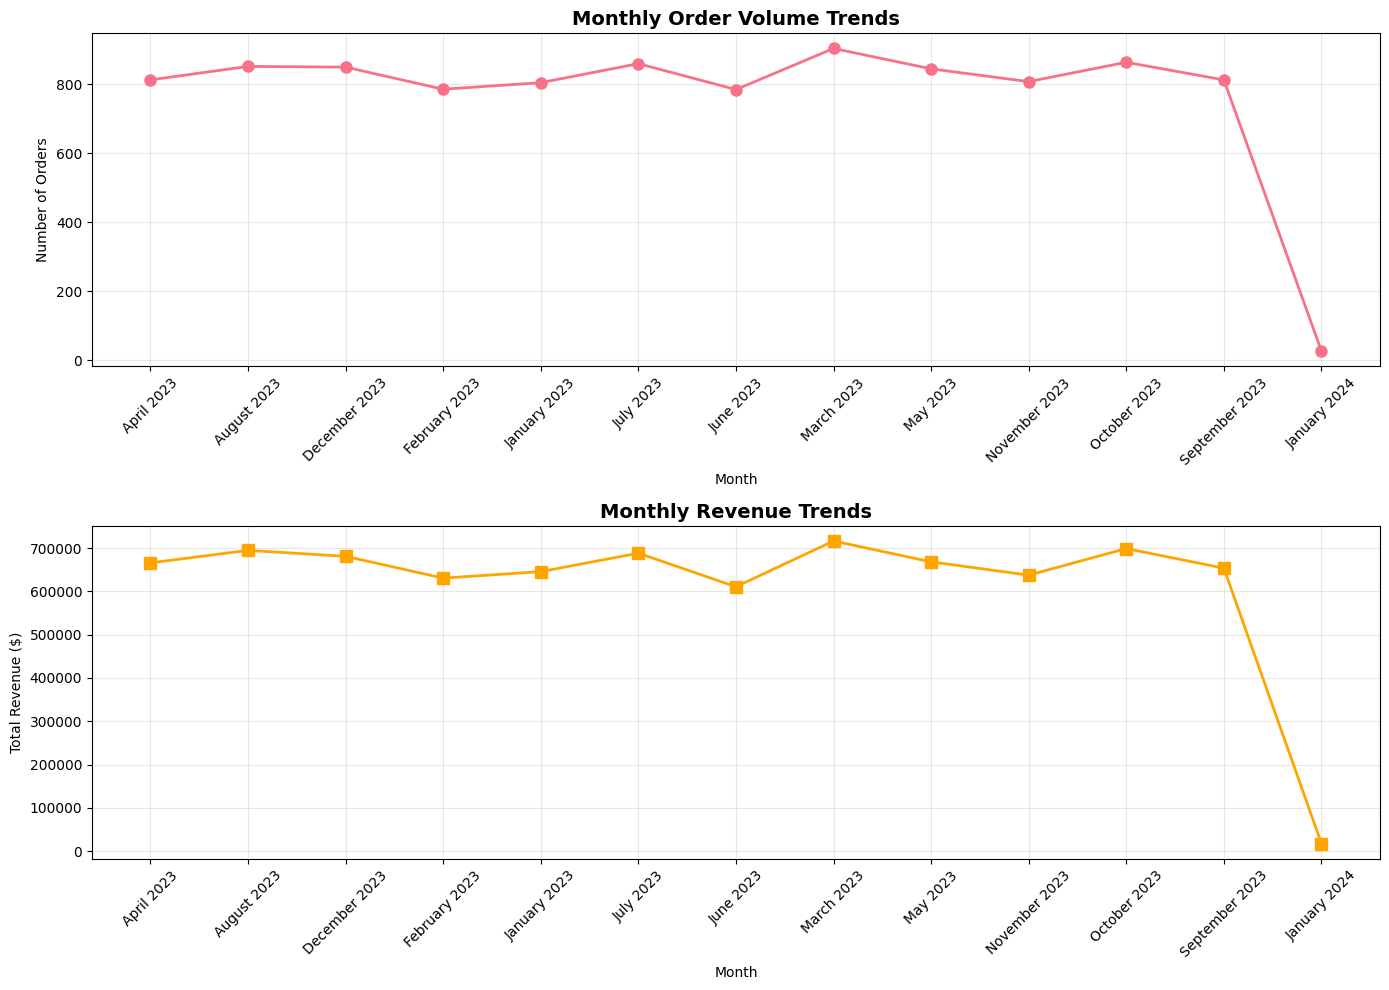

Monthly Summary:
   month_name  year  order_count
0       April  2023          812
1      August  2023          851
2    December  2023          849
3    February  2023          785
4     January  2023          804
5        July  2023          859
6        June  2023          784
7       March  2023          903
8         May  2023          844
9    November  2023          807
10    October  2023          863
11  September  2023          812
12    January  2024           27


In [9]:
# Monthly order trends
monthly_orders = final_df.groupby(['year', 'month_name']).size().reset_index(name='order_count')
monthly_orders['month_num'] = final_df.groupby(['year', 'month'])['month'].first().values
monthly_orders = monthly_orders.sort_values(['year', 'month_num'])

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Monthly order volume
axes[0].plot(range(len(monthly_orders)), monthly_orders['order_count'], marker='o', linewidth=2, markersize=8)
axes[0].set_title('Monthly Order Volume Trends', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Orders')
axes[0].grid(True, alpha=0.3)
month_labels = [f"{row['month_name']} {row['year']}" for _, row in monthly_orders.iterrows()]
axes[0].set_xticks(range(len(monthly_orders)))
axes[0].set_xticklabels(month_labels, rotation=45)

# Monthly revenue trends
monthly_revenue = final_df.groupby(['year', 'month_name'])['total_amount'].sum().reset_index()
monthly_revenue['month_num'] = final_df.groupby(['year', 'month'])['month'].first().values
monthly_revenue = monthly_revenue.sort_values(['year', 'month_num'])

axes[1].plot(range(len(monthly_revenue)), monthly_revenue['total_amount'], marker='s', linewidth=2, markersize=8, color='orange')
axes[1].set_title('Monthly Revenue Trends', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Total Revenue ($)')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(len(monthly_revenue)))
axes[1].set_xticklabels(month_labels, rotation=45)

plt.tight_layout()
plt.show()

print("Monthly Summary:")
print(monthly_orders[['month_name', 'year', 'order_count']])

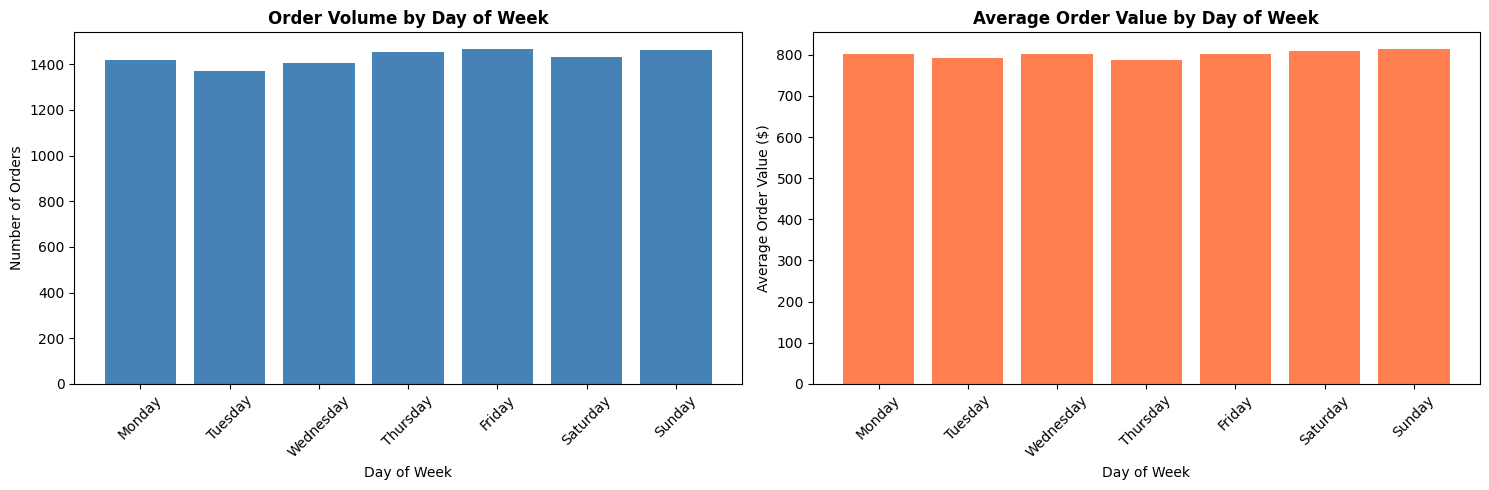


Day of Week Analysis:
             order_count  total_revenue  avg_order_value
day_of_week                                             
Monday              1418     1137568.63           802.23
Tuesday             1368     1082081.63           791.00
Wednesday           1404     1126468.28           802.33
Thursday            1453     1145695.14           788.50
Friday              1466     1174418.88           801.10
Saturday            1430     1156335.84           808.63
Sunday              1461     1189055.72           813.86


In [10]:
# Day of week analysis
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_orders = final_df.groupby('day_of_week').agg({
    'order_id': 'count',
    'total_amount': ['sum', 'mean']
}).round(2)

dow_orders.columns = ['order_count', 'total_revenue', 'avg_order_value']
dow_orders = dow_orders.reindex(day_order)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Orders by day of week
axes[0].bar(dow_orders.index, dow_orders['order_count'], color='steelblue')
axes[0].set_title('Order Volume by Day of Week', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Number of Orders')
axes[0].tick_params(axis='x', rotation=45)

# Average order value by day of week
axes[1].bar(dow_orders.index, dow_orders['avg_order_value'], color='coral')
axes[1].set_title('Average Order Value by Day of Week', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Average Order Value ($)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nDay of Week Analysis:")
print(dow_orders)

---
## Analysis 2: User Behavior Patterns

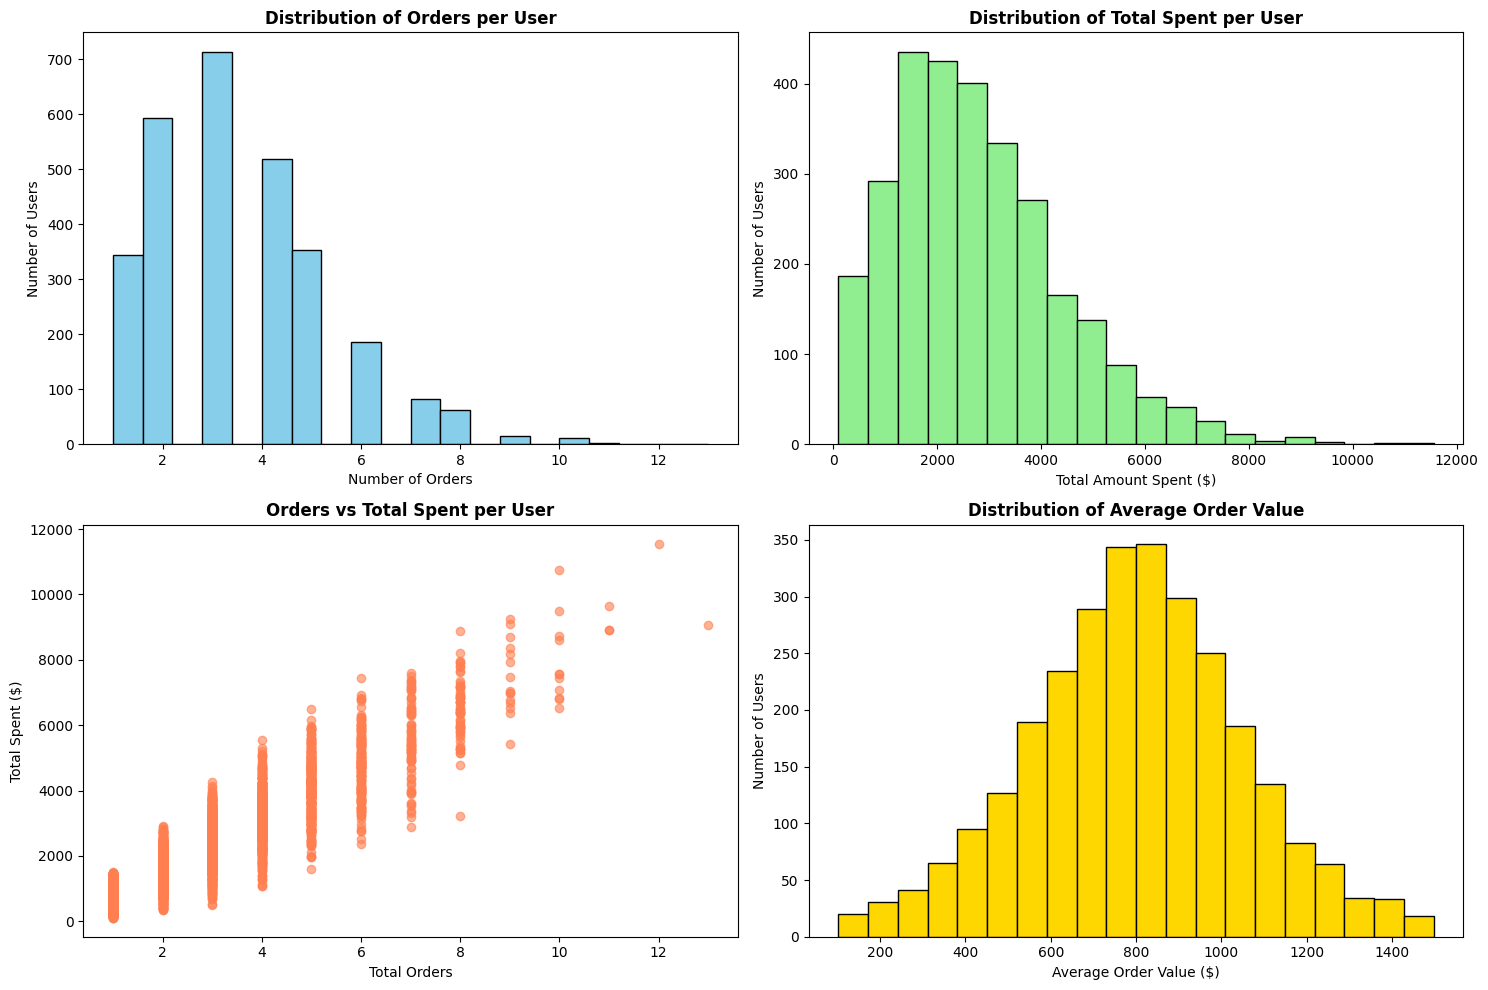

User Behavior Summary:
       total_orders   total_spent  avg_order_value
count   2883.000000   2883.000000      2883.000000
mean       3.468609   2778.919223       799.247562
std        1.792682   1627.276076       251.053066
min        1.000000    102.220000       102.220000
25%        2.000000   1563.495000       640.185000
50%        3.000000   2514.920000       800.690000
75%        4.000000   3715.145000       961.120000
max       13.000000  11556.490000      1497.420000


In [11]:
# User order frequency analysis
user_frequency = final_df.groupby(['user_id', 'name', 'city', 'membership']).agg({
    'order_id': 'count',
    'total_amount': ['sum', 'mean']
}).round(2)

user_frequency.columns = ['total_orders', 'total_spent', 'avg_order_value']
user_frequency = user_frequency.reset_index()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution of orders per user
axes[0, 0].hist(user_frequency['total_orders'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Orders per User', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of Orders')
axes[0, 0].set_ylabel('Number of Users')

# Distribution of total spent per user
axes[0, 1].hist(user_frequency['total_spent'], bins=20, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Distribution of Total Spent per User', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Total Amount Spent ($)')
axes[0, 1].set_ylabel('Number of Users')

# Orders vs Total Spent scatter plot
axes[1, 0].scatter(user_frequency['total_orders'], user_frequency['total_spent'], alpha=0.6, color='coral')
axes[1, 0].set_title('Orders vs Total Spent per User', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Total Orders')
axes[1, 0].set_ylabel('Total Spent ($)')

# Average order value distribution
axes[1, 1].hist(user_frequency['avg_order_value'], bins=20, color='gold', edgecolor='black')
axes[1, 1].set_title('Distribution of Average Order Value', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Average Order Value ($)')
axes[1, 1].set_ylabel('Number of Users')

plt.tight_layout()
plt.show()

print("User Behavior Summary:")
print(user_frequency[['total_orders', 'total_spent', 'avg_order_value']].describe())

In [12]:
# Top users analysis
print("Top 10 Users by Order Count:")
top_by_orders = user_frequency.nlargest(10, 'total_orders')[['name', 'city', 'membership', 'total_orders', 'total_spent']]
print(top_by_orders.to_string(index=False))

print("\n\nTop 10 Users by Total Spent:")
top_by_spent = user_frequency.nlargest(10, 'total_spent')[['name', 'city', 'membership', 'total_orders', 'total_spent']]
print(top_by_spent.to_string(index=False))

Top 10 Users by Order Count:
     name      city membership  total_orders  total_spent
User_2973 Hyderabad       Gold            13      9063.07
User_1515 Bangalore    Regular            12     11556.49
 User_496   Chennai    Regular            11      9634.30
 User_874      Pune       Gold            11      8916.55
User_1337 Bangalore    Regular            11      8907.50
   User_2      Pune       Gold            10      7564.12
 User_358 Bangalore       Gold            10      8610.24
 User_650   Chennai       Gold            10     10747.44
 User_789      Pune    Regular            10      6800.90
User_1201 Bangalore       Gold            10      7076.86


Top 10 Users by Total Spent:
     name      city membership  total_orders  total_spent
User_1515 Bangalore    Regular            12     11556.49
 User_650   Chennai       Gold            10     10747.44
 User_496   Chennai    Regular            11      9634.30
User_2586 Hyderabad    Regular            10      9486.61
User_2615 Ba

---
## Analysis 3: Membership Impact (Gold vs Regular)

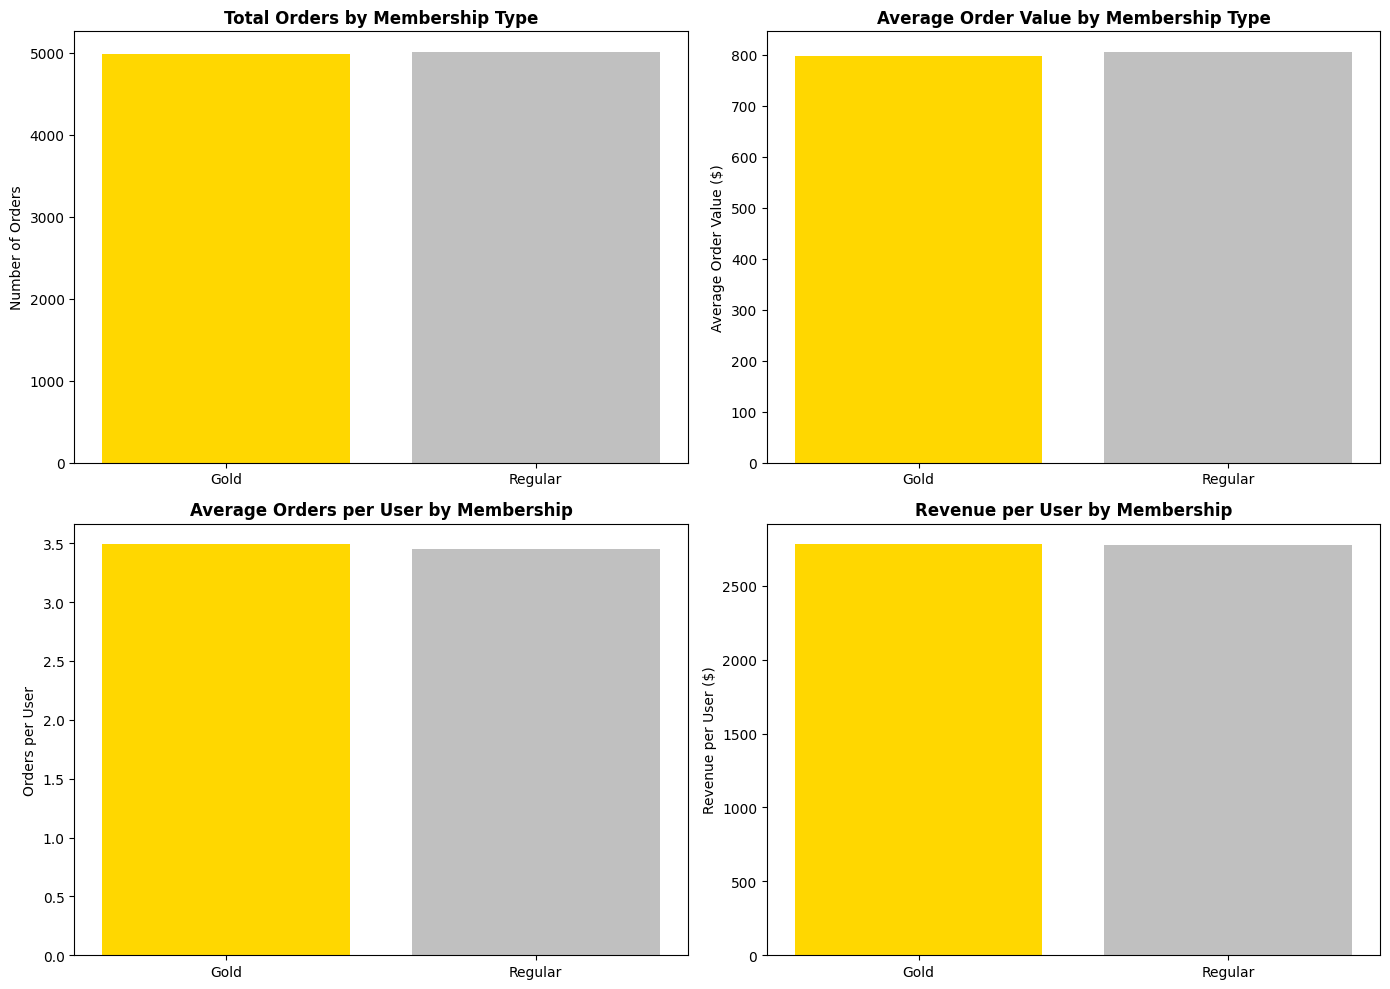


Membership Impact Analysis:
            total_orders  total_revenue  avg_order_value  unique_users  \
membership                                                               
Gold                4987     3975364.89           797.15          1430   
Regular             5013     4036259.23           805.16          1453   

            orders_per_user  revenue_per_user  
membership                                     
Gold                   3.49           2779.98  
Regular                3.45           2777.88  


In [13]:
# Membership analysis
membership_stats = final_df.groupby('membership').agg({
    'order_id': 'count',
    'total_amount': ['sum', 'mean'],
    'user_id': 'nunique'
}).round(2)

membership_stats.columns = ['total_orders', 'total_revenue', 'avg_order_value', 'unique_users']
membership_stats['orders_per_user'] = (membership_stats['total_orders'] / membership_stats['unique_users']).round(2)
membership_stats['revenue_per_user'] = (membership_stats['total_revenue'] / membership_stats['unique_users']).round(2)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Order count by membership
axes[0, 0].bar(membership_stats.index, membership_stats['total_orders'], color=['gold', 'silver'])
axes[0, 0].set_title('Total Orders by Membership Type', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Orders')

# Average order value by membership
axes[0, 1].bar(membership_stats.index, membership_stats['avg_order_value'], color=['gold', 'silver'])
axes[0, 1].set_title('Average Order Value by Membership Type', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Average Order Value ($)')

# Orders per user by membership
axes[1, 0].bar(membership_stats.index, membership_stats['orders_per_user'], color=['gold', 'silver'])
axes[1, 0].set_title('Average Orders per User by Membership', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Orders per User')

# Revenue per user by membership
axes[1, 1].bar(membership_stats.index, membership_stats['revenue_per_user'], color=['gold', 'silver'])
axes[1, 1].set_title('Revenue per User by Membership', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Revenue per User ($)')

plt.tight_layout()
plt.show()

print("\nMembership Impact Analysis:")
print(membership_stats)

In [14]:
# Statistical test for membership impact
from scipy import stats

gold_orders = final_df[final_df['membership'] == 'Gold']['total_amount']
regular_orders = final_df[final_df['membership'] == 'Regular']['total_amount']

t_stat, p_value = stats.ttest_ind(gold_orders, regular_orders)

print("Statistical Test (T-Test) Results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"\nInterpretation: {'Significant difference' if p_value < 0.05 else 'No significant difference'} in order values between Gold and Regular members")

print("\nDetailed Comparison:")
print(f"Gold Members - Mean: ${gold_orders.mean():.2f}, Std: ${gold_orders.std():.2f}")
print(f"Regular Members - Mean: ${regular_orders.mean():.2f}, Std: ${regular_orders.std():.2f}")

Statistical Test (T-Test) Results:
T-statistic: -0.9881
P-value: 0.3231

Interpretation: No significant difference in order values between Gold and Regular members

Detailed Comparison:
Gold Members - Mean: $797.15, Std: $407.39
Regular Members - Mean: $805.16, Std: $403.53


---
## Analysis 4: City-wise Performance

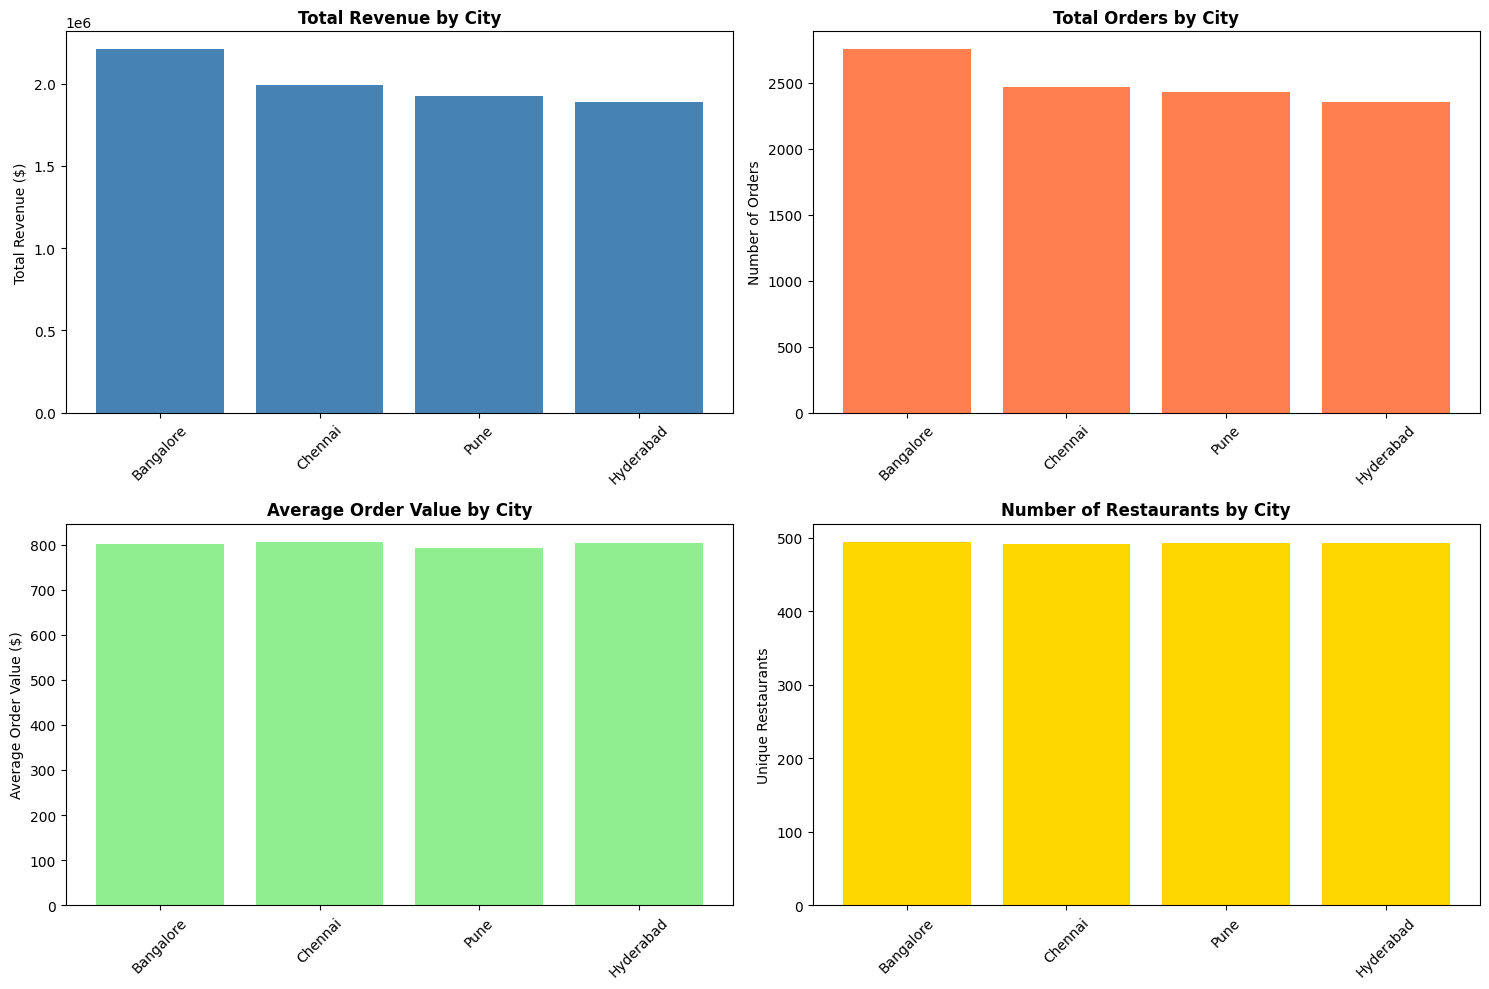

City-wise Performance Summary:
           total_orders  total_revenue  avg_order_value  unique_users  \
city                                                                    
Bangalore          2751     2206946.58           802.23           769   
Chennai            2469     1990513.03           806.20           728   
Pune               2430     1924797.93           792.10           704   
Hyderabad          2350     1889366.58           803.99           682   

           unique_restaurants  
city                           
Bangalore                 494  
Chennai                   491  
Pune                      493  
Hyderabad                 493  


In [15]:
# City-wise analysis
city_stats = final_df.groupby('city').agg({
    'order_id': 'count',
    'total_amount': ['sum', 'mean'],
    'user_id': 'nunique',
    'restaurant_id': 'nunique'
}).round(2)

city_stats.columns = ['total_orders', 'total_revenue', 'avg_order_value', 'unique_users', 'unique_restaurants']
city_stats = city_stats.sort_values('total_revenue', ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total revenue by city
axes[0, 0].bar(city_stats.index, city_stats['total_revenue'], color='steelblue')
axes[0, 0].set_title('Total Revenue by City', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Total Revenue ($)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Order count by city
axes[0, 1].bar(city_stats.index, city_stats['total_orders'], color='coral')
axes[0, 1].set_title('Total Orders by City', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Number of Orders')
axes[0, 1].tick_params(axis='x', rotation=45)

# Average order value by city
axes[1, 0].bar(city_stats.index, city_stats['avg_order_value'], color='lightgreen')
axes[1, 0].set_title('Average Order Value by City', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Average Order Value ($)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Unique restaurants by city
axes[1, 1].bar(city_stats.index, city_stats['unique_restaurants'], color='gold')
axes[1, 1].set_title('Number of Restaurants by City', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Unique Restaurants')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("City-wise Performance Summary:")
print(city_stats)

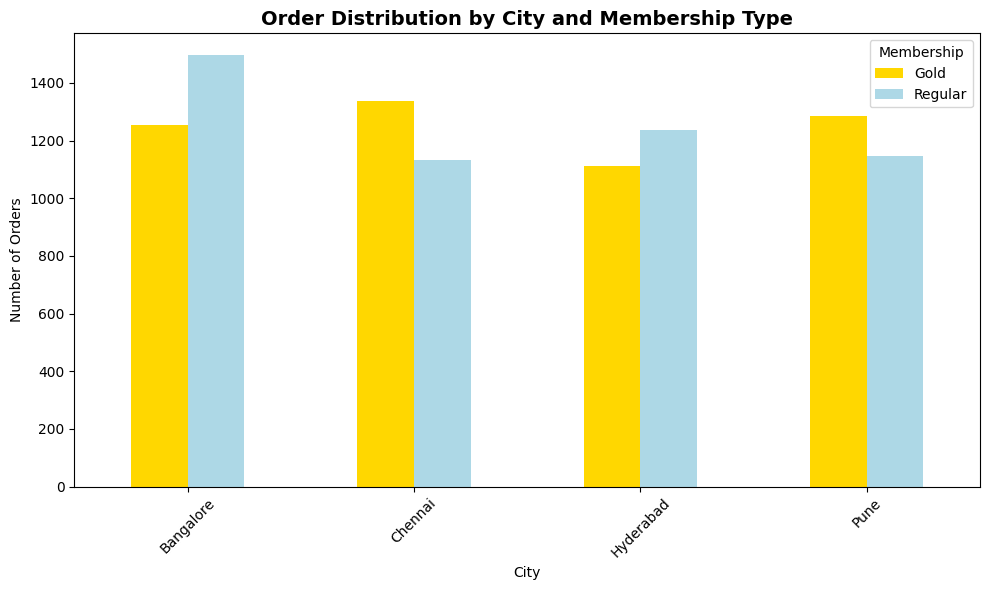


Membership Distribution by City (Percentage):
membership   Gold  Regular
city                      
Bangalore   45.58    54.42
Chennai     54.15    45.85
Hyderabad   47.32    52.68
Pune        52.84    47.16


In [16]:
# City membership distribution
city_membership = final_df.groupby(['city', 'membership']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 6))
city_membership.plot(kind='bar', ax=ax, color=['gold', 'lightblue'])
ax.set_title('Order Distribution by City and Membership Type', fontsize=14, fontweight='bold')
ax.set_xlabel('City')
ax.set_ylabel('Number of Orders')
ax.legend(title='Membership')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Calculate percentages
city_membership_pct = city_membership.div(city_membership.sum(axis=1), axis=0) * 100
print("\nMembership Distribution by City (Percentage):")
print(city_membership_pct.round(2))

---
## Analysis 5: Cuisine-wise Performance

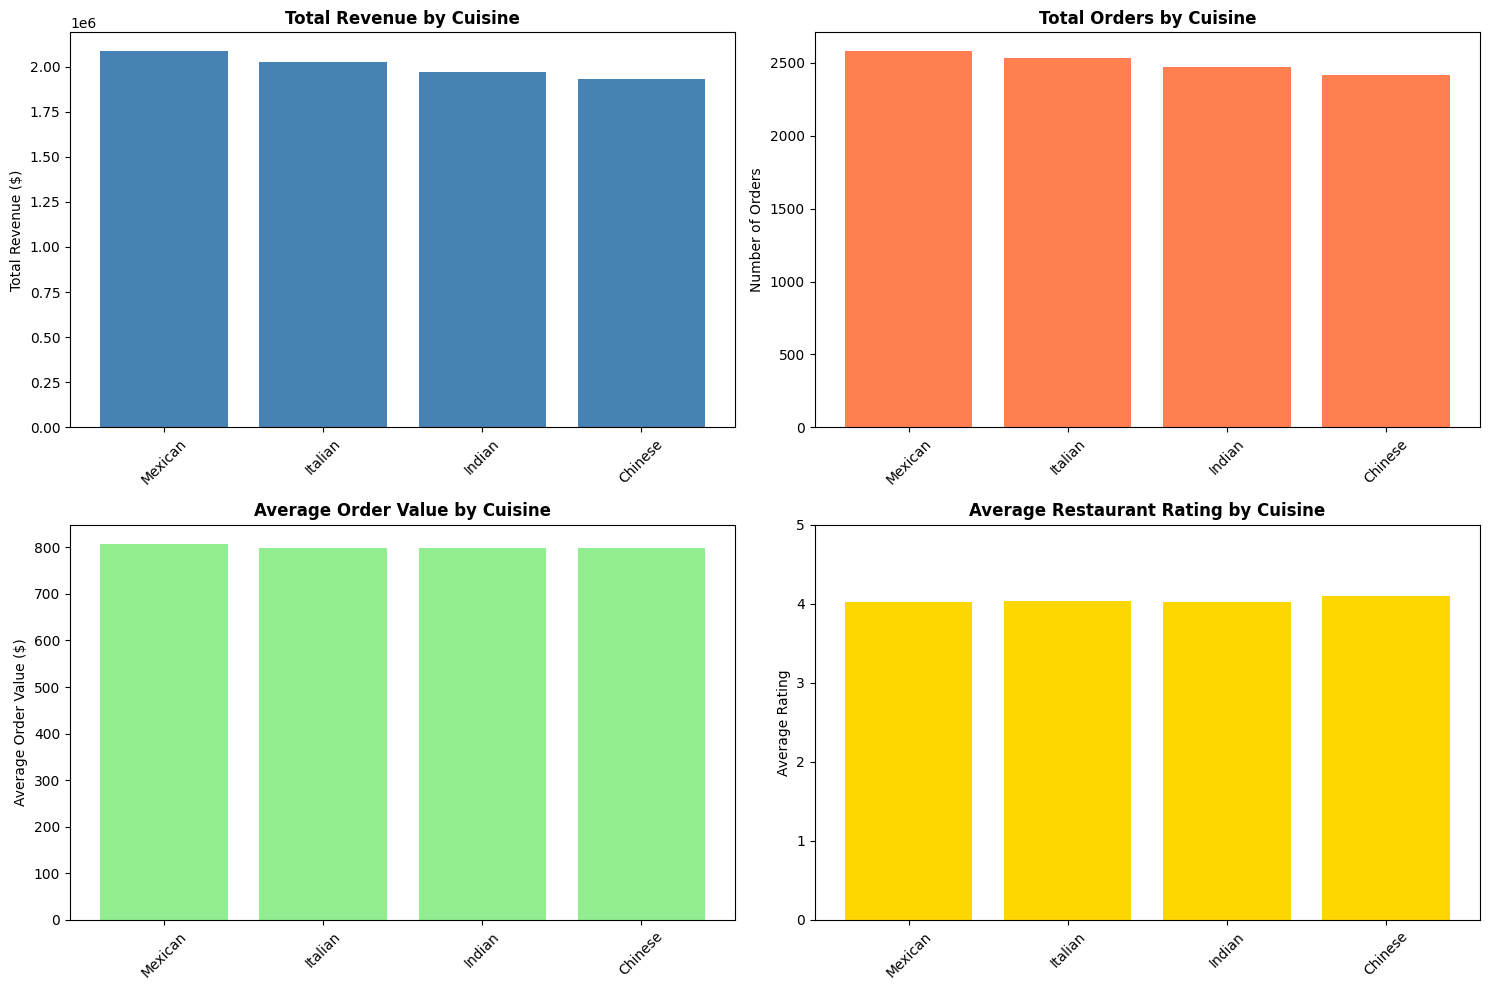

Cuisine-wise Performance Summary:
         total_orders  total_revenue  avg_order_value  avg_rating  \
cuisine                                                             
Mexican          2581     2085503.09           808.02        4.02   
Italian          2532     2024203.80           799.45        4.04   
Indian           2469     1971412.58           798.47        4.02   
Chinese          2418     1930504.65           798.39        4.10   

         unique_restaurants  
cuisine                      
Mexican                 128  
Italian                 126  
Indian                  126  
Chinese                 120  


In [17]:
# Cuisine analysis
cuisine_stats = final_df.groupby('cuisine').agg({
    'order_id': 'count',
    'total_amount': ['sum', 'mean'],
    'rating': 'mean',
    'restaurant_id': 'nunique'
}).round(2)

cuisine_stats.columns = ['total_orders', 'total_revenue', 'avg_order_value', 'avg_rating', 'unique_restaurants']
cuisine_stats = cuisine_stats.sort_values('total_revenue', ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total revenue by cuisine
axes[0, 0].bar(cuisine_stats.index, cuisine_stats['total_revenue'], color='steelblue')
axes[0, 0].set_title('Total Revenue by Cuisine', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Total Revenue ($)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Order count by cuisine
axes[0, 1].bar(cuisine_stats.index, cuisine_stats['total_orders'], color='coral')
axes[0, 1].set_title('Total Orders by Cuisine', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Number of Orders')
axes[0, 1].tick_params(axis='x', rotation=45)

# Average order value by cuisine
axes[1, 0].bar(cuisine_stats.index, cuisine_stats['avg_order_value'], color='lightgreen')
axes[1, 0].set_title('Average Order Value by Cuisine', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Average Order Value ($)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Average rating by cuisine
axes[1, 1].bar(cuisine_stats.index, cuisine_stats['avg_rating'], color='gold')
axes[1, 1].set_title('Average Restaurant Rating by Cuisine', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Average Rating')
axes[1, 1].set_ylim(0, 5)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Cuisine-wise Performance Summary:")
print(cuisine_stats)

In [18]:
# Top restaurants by cuisine
print("Top 3 Restaurants by Total Revenue for Each Cuisine:")
print("="*70)

for cuisine in final_df['cuisine'].unique():
    if pd.notna(cuisine):
        top_restaurants = final_df[final_df['cuisine'] == cuisine].groupby('restaurant_name').agg({
            'total_amount': 'sum',
            'order_id': 'count',
            'rating': 'first'
        }).round(2)
        top_restaurants.columns = ['total_revenue', 'total_orders', 'rating']
        top_restaurants = top_restaurants.sort_values('total_revenue', ascending=False).head(3)
        
        print(f"\n{cuisine} Cuisine:")
        print(top_restaurants.to_string())
        print()

Top 3 Restaurants by Total Revenue for Each Cuisine:

Mexican Cuisine:
                 total_revenue  total_orders  rating
restaurant_name                                     
Restaurant_484        27051.49            28     4.2
Restaurant_134        25791.23            30     4.3
Restaurant_440        25467.45            27     3.8


Indian Cuisine:
                 total_revenue  total_orders  rating
restaurant_name                                     
Restaurant_19         29289.52            26     3.6
Restaurant_383        24955.59            36     3.1
Restaurant_231        23069.40            32     4.1


Chinese Cuisine:
                 total_revenue  total_orders  rating
restaurant_name                                     
Restaurant_287        29460.47            35     4.7
Restaurant_188        24698.82            30     4.6
Restaurant_25         24317.80            26     3.7


Italian Cuisine:
                 total_revenue  total_orders  rating
restaurant_name          

---
## Analysis 6: Revenue Distribution and Seasonality

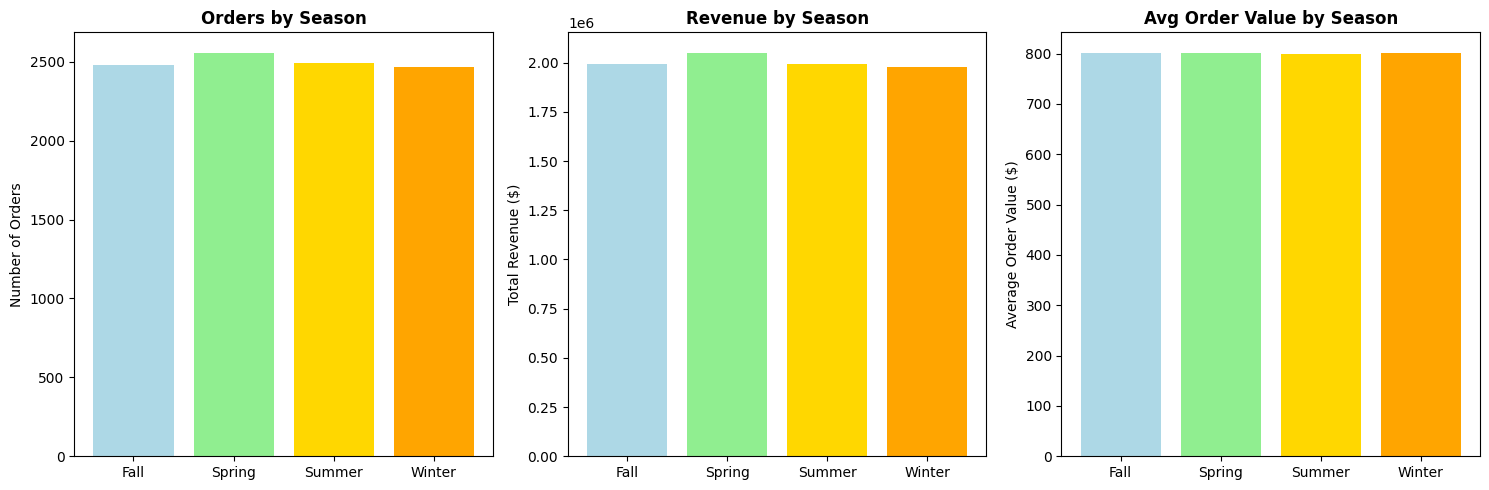

Seasonality Analysis:
        total_orders  total_revenue  avg_order_value
season                                              
Fall            2482     1990798.23           802.09
Spring          2559     2051264.77           801.59
Summer          2494     1994369.96           799.67
Winter          2465     1975191.16           801.29


In [19]:
# Seasonality analysis
season_stats = final_df.groupby('season').agg({
    'order_id': 'count',
    'total_amount': ['sum', 'mean']
}).round(2)

season_stats.columns = ['total_orders', 'total_revenue', 'avg_order_value']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Orders by season
axes[0].bar(season_stats.index, season_stats['total_orders'], color=['lightblue', 'lightgreen', 'gold', 'orange'])
axes[0].set_title('Orders by Season', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Orders')

# Revenue by season
axes[1].bar(season_stats.index, season_stats['total_revenue'], color=['lightblue', 'lightgreen', 'gold', 'orange'])
axes[1].set_title('Revenue by Season', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Total Revenue ($)')

# Average order value by season
axes[2].bar(season_stats.index, season_stats['avg_order_value'], color=['lightblue', 'lightgreen', 'gold', 'orange'])
axes[2].set_title('Avg Order Value by Season', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Average Order Value ($)')

plt.tight_layout()
plt.show()

print("Seasonality Analysis:")
print(season_stats)

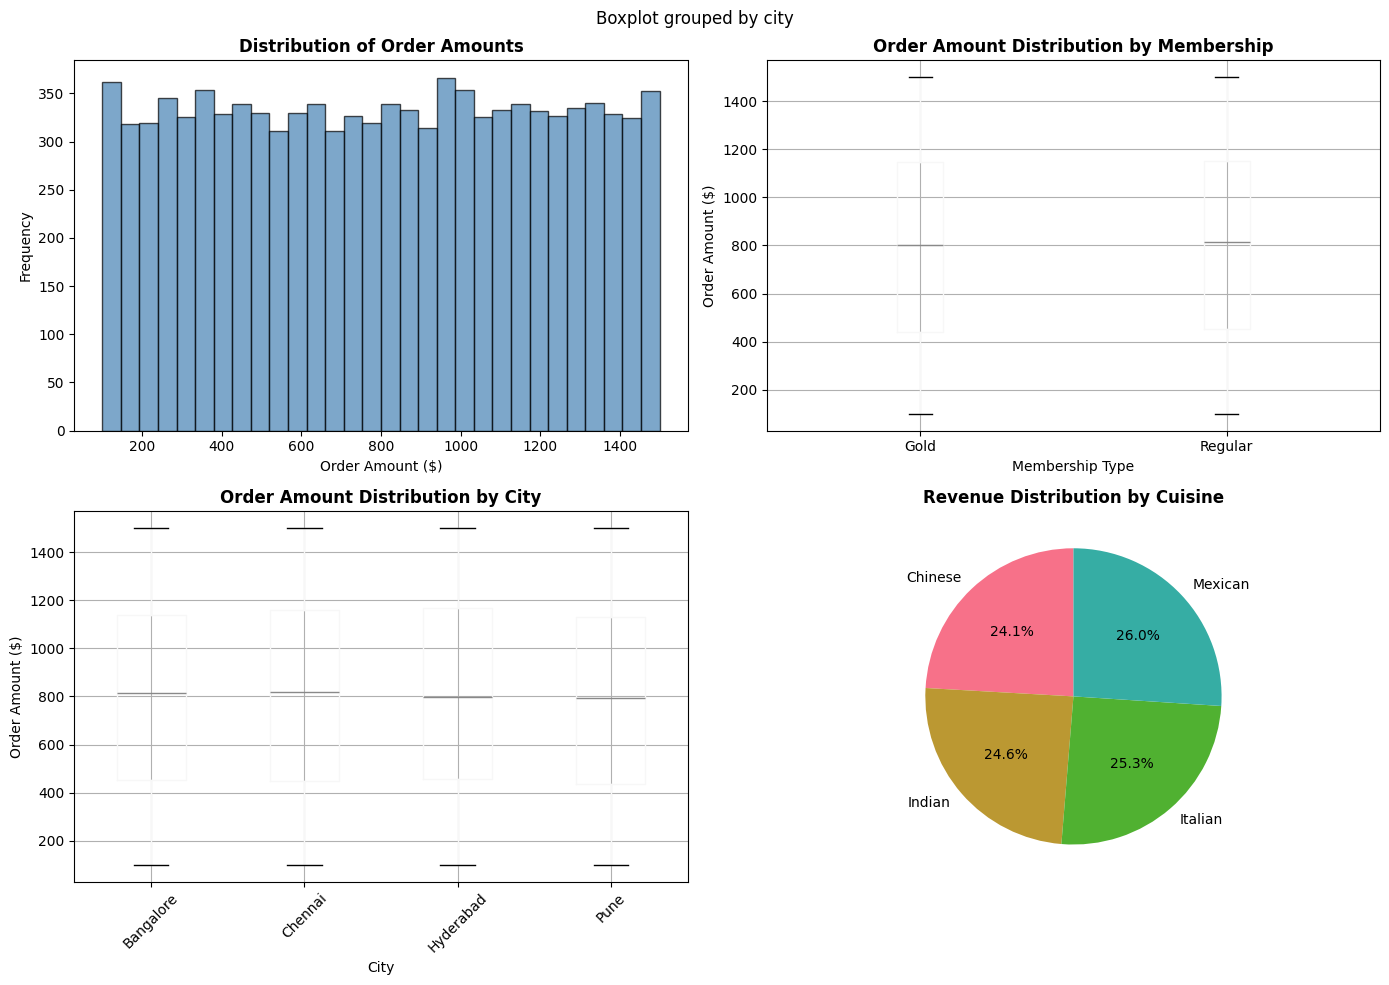


Revenue Distribution Statistics:
count    10000.000000
mean       801.162412
std        405.458753
min        100.200000
25%        446.310000
50%        806.295000
75%       1149.227500
max       1499.830000
Name: total_amount, dtype: float64


In [20]:
# Revenue distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Overall revenue distribution
axes[0, 0].hist(final_df['total_amount'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Order Amounts', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Order Amount ($)')
axes[0, 0].set_ylabel('Frequency')

# Box plot by membership
final_df.boxplot(column='total_amount', by='membership', ax=axes[0, 1])
axes[0, 1].set_title('Order Amount Distribution by Membership', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Membership Type')
axes[0, 1].set_ylabel('Order Amount ($)')

# Box plot by city
final_df.boxplot(column='total_amount', by='city', ax=axes[1, 0])
axes[1, 0].set_title('Order Amount Distribution by City', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('City')
axes[1, 0].set_ylabel('Order Amount ($)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Revenue by cuisine (pie chart)
cuisine_revenue = final_df.groupby('cuisine')['total_amount'].sum()
axes[1, 1].pie(cuisine_revenue.values, labels=cuisine_revenue.index, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Revenue Distribution by Cuisine', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nRevenue Distribution Statistics:")
print(final_df['total_amount'].describe())

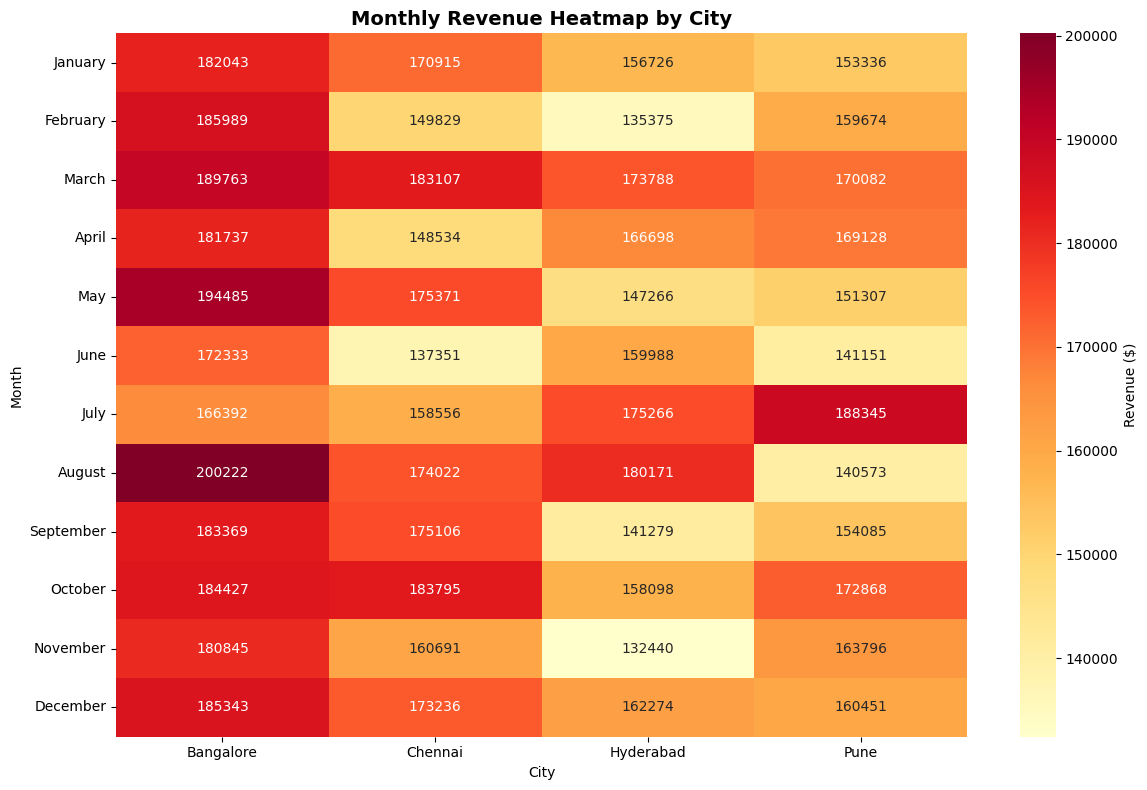

In [21]:
# Monthly heatmap for revenue
pivot_revenue = final_df.pivot_table(values='total_amount', index='month_name', columns='city', aggfunc='sum')
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
pivot_revenue = pivot_revenue.reindex([m for m in month_order if m in pivot_revenue.index])

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot_revenue, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Revenue ($)'})
ax.set_title('Monthly Revenue Heatmap by City', fontsize=14, fontweight='bold')
ax.set_xlabel('City')
ax.set_ylabel('Month')
plt.tight_layout()
plt.show()

---
## Executive Summary

In [22]:
# Generate comprehensive summary
print("="*70)
print("FOOD DELIVERY DATA ANALYSIS - EXECUTIVE SUMMARY")
print("="*70)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   • Total Orders: {len(final_df):,}")
print(f"   • Total Revenue: ${final_df['total_amount'].sum():,.2f}")
print(f"   • Average Order Value: ${final_df['total_amount'].mean():.2f}")
print(f"   • Unique Users: {final_df['user_id'].nunique():,}")
print(f"   • Unique Restaurants: {final_df['restaurant_id'].nunique():,}")
print(f"   • Date Range: {final_df['order_date'].min().strftime('%Y-%m-%d')} to {final_df['order_date'].max().strftime('%Y-%m-%d')}")

print(f"\n👥 MEMBERSHIP INSIGHTS:")
gold_pct = (membership_stats.loc['Gold', 'total_orders'] / membership_stats['total_orders'].sum()) * 100
print(f"   • Gold members account for {gold_pct:.1f}% of all orders")
print(f"   • Gold members have {membership_stats.loc['Gold', 'avg_order_value']:.2f} avg order value vs {membership_stats.loc['Regular', 'avg_order_value']:.2f} for Regular")
print(f"   • Gold members order {membership_stats.loc['Gold', 'orders_per_user']:.1f}x more frequently")

print(f"\n🏙️  CITY PERFORMANCE:")
top_city = city_stats.index[0]
print(f"   • Top performing city: {top_city} (${city_stats.loc[top_city, 'total_revenue']:,.2f} revenue)")
print(f"   • Highest AOV city: {city_stats.sort_values('avg_order_value', ascending=False).index[0]}")
print(f"   • Most active city: {city_stats.sort_values('total_orders', ascending=False).index[0]}")

print(f"\n🍽️  CUISINE INSIGHTS:")
top_cuisine = cuisine_stats.index[0]
print(f"   • Top revenue cuisine: {top_cuisine} (${cuisine_stats.loc[top_cuisine, 'total_revenue']:,.2f})")
print(f"   • Highest AOV cuisine: {cuisine_stats.sort_values('avg_order_value', ascending=False).index[0]}")
print(f"   • Most popular cuisine: {cuisine_stats.sort_values('total_orders', ascending=False).index[0]}")

print(f"\n📅 SEASONALITY PATTERNS:")
top_season = season_stats.sort_values('total_revenue', ascending=False).index[0]
print(f"   • Peak season: {top_season} (${season_stats.loc[top_season, 'total_revenue']:,.2f} revenue)")
print(f"   • Lowest season: {season_stats.sort_values('total_revenue').index[0]}")

print(f"\n📈 KEY METRICS:")
print(f"   • Revenue per user: ${final_df.groupby('user_id')['total_amount'].sum().mean():.2f}")
print(f"   • Orders per user: {final_df.groupby('user_id')['order_id'].count().mean():.2f}")
print(f"   • Average restaurant rating: {final_df['rating'].mean():.2f}/5.0")

print("\n" + "="*70)
print("RECOMMENDATIONS:")
print("="*70)
print("1. Focus on Gold member retention and acquisition programs")
print("2. Expand presence in top-performing cities (especially " + top_city + ")")
print("3. Promote " + top_cuisine + " cuisine partnerships for growth")
print("4. Implement seasonal promotions during " + season_stats.sort_values('total_revenue').index[0] + "")
print("5. Target high-value customers with personalized offers")
print("="*70)

FOOD DELIVERY DATA ANALYSIS - EXECUTIVE SUMMARY

📊 DATASET OVERVIEW:
   • Total Orders: 10,000
   • Total Revenue: $8,011,624.12
   • Average Order Value: $801.16
   • Unique Users: 2,883
   • Unique Restaurants: 500
   • Date Range: 2023-01-01 to 2024-01-01

👥 MEMBERSHIP INSIGHTS:
   • Gold members account for 49.9% of all orders
   • Gold members have 797.15 avg order value vs 805.16 for Regular
   • Gold members order 3.5x more frequently

🏙️  CITY PERFORMANCE:
   • Top performing city: Bangalore ($2,206,946.58 revenue)
   • Highest AOV city: Chennai
   • Most active city: Bangalore

🍽️  CUISINE INSIGHTS:
   • Top revenue cuisine: Mexican ($2,085,503.09)
   • Highest AOV cuisine: Mexican
   • Most popular cuisine: Mexican

📅 SEASONALITY PATTERNS:
   • Peak season: Spring ($2,051,264.77 revenue)
   • Lowest season: Winter

📈 KEY METRICS:
   • Revenue per user: $2778.92
   • Orders per user: 3.47
   • Average restaurant rating: 4.05/5.0

RECOMMENDATIONS:
1. Focus on Gold member retent